In [1]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import utils.network as network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import utils.data as dt


# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Ball detector

Comparison between approaches.

Here im not sure about the ts


Im gonna do with 10 ts and add those results to the 20 and 100 ts . But does it make sense to equate computational power? I am gonna say that I had to do that due to computational limitations


So:

I am comparing the diferent approaches, and I am comparing 20 ts for 50 epochs to 100 ts for 25 epochs and also showing the training time. This way it would be clearer if the approach was undoubtly better.

In [2]:
# Train several models
dataset_folder = 'cropped_classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
batch_size = 50
quantization = 8
# all_num_steps = [20, 100]
print(f"TRAINING MODELS WITH QUANTIZATION {quantization}")
print("-"*50)
print("CREATING DATALOADERS")
print("-"*50)
labels = ['X', 'Y', 'Radius']
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization, labels=labels)
testset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
evalset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset_quant, batch_size=batch_size, shuffle=True)
evalloader = DataLoader(evalset_quant, batch_size=batch_size, shuffle=True)
inferenceloader = DataLoader(testset_quant, batch_size=1, shuffle=False)
img_shape_quant = trainset_quant.image_shape
bins_factor = trainset_quant.quantization / trainset_quant.label_quantization
models_numsteps = [
    (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN2LImageRegression(img_shape_quant), 20),
    # (network.SCNN2LImageRegression(img_shape_quant), 100),
    (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN3LImageRegression(img_shape_quant), 20),
    # (network.SCNN3LImageRegression(img_shape_quant), 100),
]
df = pd.DataFrame(columns=['Model', 'Num Steps', 'Error', 'Inference Time', 'Training Time'])

print("-"*50)
print("TRAINING MODELS")
print("-"*50)


for model, num_steps in models_numsteps:
    model_type = model.name
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training model {model_type} with {num_steps} time steps")
    # num_epochs = 25 if num_steps == 100 else 50
    num_epochs = 50
    print(f"Training for {num_epochs} epochs")
    model.to(device)
    start_train_time = time.perf_counter()
    model.start_training(trainloader, optimizer, device, 
                         validationloader=evalloader, 
                         num_steps=num_steps, num_epochs=num_epochs, plot=False)
    training_time = time.perf_counter() - start_train_time
    save_path = f'models/{model_type}_q{quantization}_{num_steps}ts_{num_epochs}e.pt'
    # torch.save({
    #     'model_state_dict': model.state_dict(),
    #     'training_params': model.training_params,
    # }, save_path)
    error = model.evaluate(testloader, device, num_steps=num_steps, print_results=False) # I am evaluating all models with 20 time steps for better comparison
    error = np.linalg.norm(error).item()
    inference_time = network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=num_steps, num_batches=5)

    new_row = pd.DataFrame({
        'Model': [model_type],
        'Num Steps': [num_steps],
        'Error': [error],
        'Inference Time': [inference_time],
        'Training Time': [training_time]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    print(f"Model {model_type} with {num_steps} time steps: Error={error:.4f}, Inference Time={inference_time:.6f} sec/image, Training Time={training_time:.2f} sec")
    print("-"*50)
    del model
    torch.cuda.empty_cache()
    

df.to_csv(f'models/q{quantization}_results.csv', index=False)

TRAINING MODELS WITH QUANTIZATION 8
--------------------------------------------------
CREATING DATALOADERS
--------------------------------------------------
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Flattened feature size: 8064

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_23484\1836292822.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Epoch 1/50, Loss: 2527.1265, Validation Error: 35.5679 pixels
Epoch 2/50, Loss: 1040.1923, Validation Error: 19.8574 pixels
Epoch 3/50, Loss: 335.8372, Validation Error: 12.6846 pixels
Epoch 4/50, Loss: 171.1183, Validation Error: 9.2564 pixels
Epoch 5/50, Loss: 101.3706, Validation Error: 7.8981 pixels
Epoch 6/50, Loss: 71.2026, Validation Error: 6.8723 pixels
Epoch 7/50, Loss: 169.0764, Validation Error: 10.2634 pixels
Epoch 8/50, Loss: 87.5408, Validation Error: 5.4254 pixels
Epoch 9/50, Loss: 44.4160, Validation Error: 5.1743 pixels
Epoch 10/50, Loss: 31.8541, Validation Error: 4.8936 pixels
Epoch 11/50, Loss: 29.7555, Validation Error: 4.6719 pixels
Epoch 12/50, Loss: 22.6618, Validation Error: 4.5085 pixels
Epoch 13/50, Loss: 20.5741, Validation Error: 4.1294 pixels
Epoch 14/50, Loss: 17.7088, Validation Error: 3.8487 pixels
Epoch 15/50, Loss: 16.2722, Validation Error: 3.7848 pixels
Epoch 16/50, Loss: 14.5040, Validation Error: 3.5374 pixels
Epoch 17/50, Loss: 13.5329, Validatio

In [3]:
# Train several models
dataset_folder = 'cropped_classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
batch_size = 50
quantization = 4
# all_num_steps = [20, 100]
print(f"TRAINING MODELS WITH QUANTIZATION {quantization}")
print("-"*50)
print("CREATING DATALOADERS")
print("-"*50)
labels = ['X', 'Y', 'Radius']
trainset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='train', dataset_type="ball", augment=True, quantization=quantization, labels=labels)
testset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
evalset_quant = dt.BallTrackingDatasetImages(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=quantization, labels=labels)
trainloader = DataLoader(trainset_quant, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset_quant, batch_size=batch_size, shuffle=True)
evalloader = DataLoader(evalset_quant, batch_size=batch_size, shuffle=True)
inferenceloader = DataLoader(testset_quant, batch_size=1, shuffle=False)
img_shape_quant = trainset_quant.image_shape
bins_factor = trainset_quant.quantization / trainset_quant.label_quantization
models_numsteps = [
    (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN2LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN2LImageRegression(img_shape_quant), 20),
    # (network.SCNN2LImageRegression(img_shape_quant), 100),
    (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 20),
    # (network.SCNN3LImageClassification(img_shape_quant, bins_factor=bins_factor), 100),
    (network.SCNN3LImageRegression(img_shape_quant), 20),
    # (network.SCNN3LImageRegression(img_shape_quant), 100),
]
df = pd.DataFrame(columns=['Model', 'Num Steps', 'Error', 'Inference Time', 'Training Time'])

print("-"*50)
print("TRAINING MODELS")
print("-"*50)


for model, num_steps in models_numsteps:
    model_type = model.name
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training model {model_type} with {num_steps} time steps")
    # num_epochs = 25 if num_steps == 100 else 50
    num_epochs = 50
    print(f"Training for {num_epochs} epochs")
    model.to(device)
    start_train_time = time.perf_counter()
    model.start_training(trainloader, optimizer, device, 
                         validationloader=evalloader, 
                         num_steps=num_steps, num_epochs=num_epochs, plot=False)
    training_time = time.perf_counter() - start_train_time
    save_path = f'models/{model_type}_q{quantization}_{num_steps}ts_{num_epochs}e.pt'
    # torch.save({
    #     'model_state_dict': model.state_dict(),
    #     'training_params': model.training_params,
    # }, save_path)
    error = model.evaluate(testloader, device, num_steps=num_steps, print_results=False) # I am evaluating all models with 20 time steps for better comparison
    error = np.linalg.norm(error).item()
    inference_time = network.measure_inference_time_per_image(model, inferenceloader, device, num_steps=num_steps, num_batches=5)

    new_row = pd.DataFrame({
        'Model': [model_type],
        'Num Steps': [num_steps],
        'Error': [error],
        'Inference Time': [inference_time],
        'Training Time': [training_time]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    print(f"Model {model_type} with {num_steps} time steps: Error={error:.4f}, Inference Time={inference_time:.6f} sec/image, Training Time={training_time:.2f} sec")
    print("-"*50)
    del model
    torch.cuda.empty_cache()
    

df.to_csv(f'models/q{quantization}_results.csv', index=False)

TRAINING MODELS WITH QUANTIZATION 4
--------------------------------------------------
CREATING DATALOADERS
--------------------------------------------------
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='train' size: 752
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='test' size: 162
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Filtered to 1075 rows for dataset type: ball
Split sizes: train=752, val=161, test=162, total=1075
Final dataset split='val' size: 161
Shape of the images: torch.Size([2, 102, 170])
Label shape: (170, 102)
Flattened featur

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_23484\2415557250.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Epoch 1/50, Loss: 10060.5397, Validation Error: 71.2925 pixels
Epoch 2/50, Loss: 4052.5077, Validation Error: 40.2080 pixels
Epoch 3/50, Loss: 1241.4938, Validation Error: 21.4229 pixels
Epoch 4/50, Loss: 433.9808, Validation Error: 15.7075 pixels
Epoch 5/50, Loss: 229.4964, Validation Error: 12.2805 pixels
Epoch 6/50, Loss: 178.2405, Validation Error: 10.8023 pixels
Epoch 7/50, Loss: 129.1512, Validation Error: 10.7056 pixels
Epoch 8/50, Loss: 135.0944, Validation Error: 9.3465 pixels
Epoch 9/50, Loss: 85.8630, Validation Error: 8.9634 pixels
Epoch 10/50, Loss: 80.4507, Validation Error: 8.7983 pixels
Epoch 11/50, Loss: 90.2515, Validation Error: 8.3812 pixels
Epoch 12/50, Loss: 76.6829, Validation Error: 7.9525 pixels
Epoch 13/50, Loss: 70.5202, Validation Error: 6.8341 pixels
Epoch 14/50, Loss: 69.8876, Validation Error: 7.6801 pixels
Epoch 15/50, Loss: 65.7047, Validation Error: 6.9085 pixels
Epoch 16/50, Loss: 64.2353, Validation Error: 8.8982 pixels
Epoch 17/50, Loss: 66.6888, Va

Maybe add the weighted average thing and do it for the 2D Ball detector. If I do it for the image tracker, i need to train a new model...

In [1]:
model1 = network.load_model('models/VideoTrackerClassWAvg_q8_10ts_50e.pt', network.SCNN_Video_Tracker_Class, device)
network.plot_timestep_curve(model1, testloader, device, identifier="T: WAvg, I: WAvg", regression=True, interval = [1, 20, 1])
model1.weighted_avg = False
network.plot_timestep_curve(model1, testloader, device, identifier="T: WAvg, I: No WAvg", regression=True, interval = [1, 20, 1])
model2 = network.load_model('models/VideoTrackerClass_q8_10ts_30e.pt', network.SCNN_Video_Tracker_Class, device)
network.plot_timestep_curve(model2, testloader, device, identifier="T: No WAvg, I: No WAvg", regression=True, interval = [1, 20, 1])
model2.weighted_avg = True
network.plot_timestep_curve(model2, testloader, device, identifier="T: No WAvg, I: WAvg", regression=True, interval = [1, 20, 1])
plt.legend()

NameError: name 'network' is not defined

# 3D Ball Tracker

Motivate timesteps

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

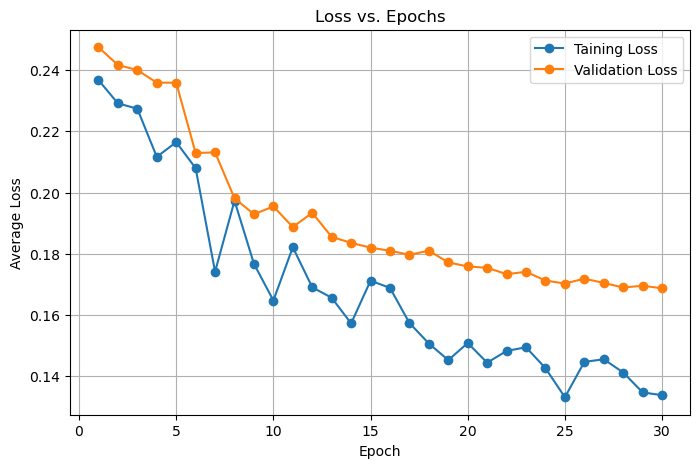

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Error for x_cam: 4.4603 pixels
Average Error for y_cam: 1.1969 pixels
Average Error for R_cam: 0.5166 pixels
Best model error: 4.646941254224549
Model saved at models/VideoClassification_q8_1ts_30e.pt
Training with num_steps=2
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2278, Validation Loss: 0.2501 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2196, Validation Loss: 0.2388 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/30, Training Loss: 0.2242, Validation Loss: 0.2215 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1874, Validation Loss: 0.2133 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/30, Training Loss: 0.1731, Validation Loss: 0.1976 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/30, Training Loss: 0.1768, Validation Loss: 0.1936 pixe

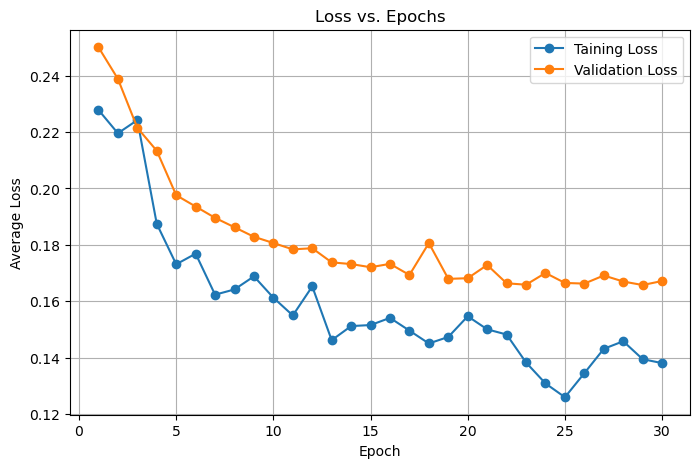

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.7331 pixels
Average Error for y_cam: 0.9872 pixels
Average Error for R_cam: 0.4703 pixels
Best model error: 2.049272397775702
Model saved at models/VideoClassification_q8_2ts_29e.pt
Training with num_steps=5
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2300, Validation Loss: 0.2407 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2279, Validation Loss: 0.2423 pixels
Epoch 3/30, Training Loss: 0.2109, Validation Loss: 0.2231 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.2042, Validation Loss: 0.2024 pixels
Model saved at models/best_model_current_training.p

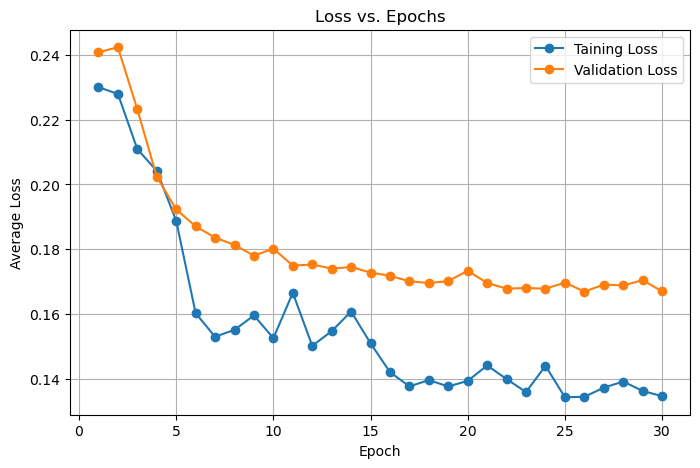

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.7514 pixels
Average Error for y_cam: 0.9245 pixels
Average Error for R_cam: 0.4631 pixels
Best model error: 2.0338295561565225
Model saved at models/VideoClassification_q8_5ts_26e.pt
Training with num_steps=10
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2275, Validation Loss: 0.2402 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2244, Validation Loss: 0.2482 pixels
Epoch 3/30, Training Loss: 0.2181, Validation Loss: 0.2153 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1901, Validation Loss: 0.2074 pixels
Model saved at models/best_model_current_training

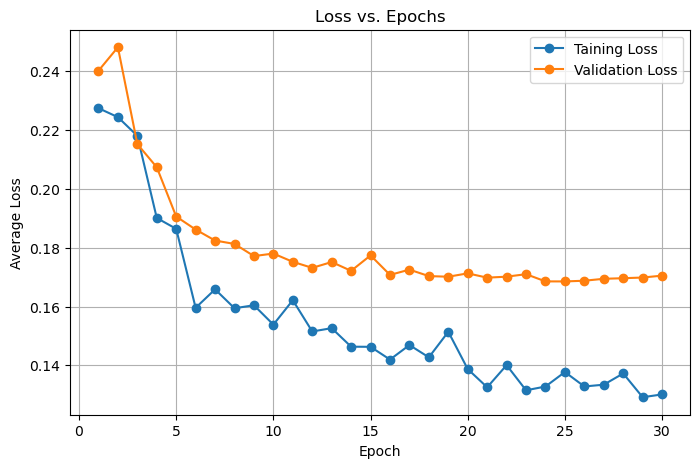

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.3700 pixels
Average Error for y_cam: 1.0741 pixels
Average Error for R_cam: 0.4779 pixels
Best model error: 1.8052950918364563
Model saved at models/VideoClassification_q8_10ts_25e.pt
Training with num_steps=20
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2346, Validation Loss: 0.2378 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2188, Validation Loss: 0.2578 pixels
Epoch 3/30, Training Loss: 0.1868, Validation Loss: 0.2073 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1773, Validation Loss: 0.1912 pixels
Model saved at models/best_model_current_trainin

In [ ]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [1, 2, 5, 10, 20, 50]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 30

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

In [3]:
dataset_path = 'data/simulator/dataset_python_sim2'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'{dataset_path}/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
# testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
# validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
# testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
# valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

models = [
    'models/VideoClassification_q8_1ts_30e.pt',
    'models/VideoClassification_q8_2ts_29e.pt',
    'models/VideoClassification_q8_5ts_26e.pt',
    'models/VideoClassification_q8_10ts_25e.pt',
    'models/VideoClassification_q8_20ts_28e.pt'
]

for model_path in models:
    print(f"Evaluating model {model_path}")
    model = network.load_model(model_path, network.SCNNVideoClassification, trainset_in, device)
    num_steps = model.training_params['num_steps']
    error = model.evaluate(trainloader_in, device, num_steps=num_steps, print_results=True) # I am evaluating all models with 20 time steps for better comparison
    error = np.linalg.norm(error).item()
    print(f"Model {model.name} with {num_steps} time steps: Error={error:.4f}")

Loading dataset from data/simulator/dataset_python_sim2 with accumulation time 10ms
Loaded 12254 rows from data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Found 87 sequences in data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=60, val=13, test=14, total=87
Final dataset split='train' size: 60

Evaluating model models/VideoClassification_q8_1ts_30e.pt
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Average Error for x_cam: 3.1154 pixels
Average Error for y_cam: 0.9444 pixels
Average Error for R_cam: 0.4295 pixels
Model VideoClassification with 1 time steps: Error=3.2836
Evaluating model models/VideoClassification_q8_2ts_29e.pt
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 1.4365 pixels
Average Error for y_cam: 0.9314 pixels
Average Error for R_cam: 0.3826 pixels
Model VideoClassification with 2 time steps: Error=1.7542
Evaluating model models/VideoClassification_q8_5ts_26e.pt
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 1.4477 pixels
Average Error for y_cam: 0.7651 pixels
Average Error for R_cam: 0.4265 pixels
Model VideoClassification with 5 time

In [6]:
dataset_folder = 'data/simulator'
dataset_path1 = os.path.join(dataset_folder, 'dataset_python_sim')
dataset_path2 = os.path.join(dataset_folder, 'dataset_python_sim2')
trajectories_csv1 = os.path.join(dataset_path1, 'trajectories.csv')
trajectories_csv2 = os.path.join(dataset_path2, 'trajectories.csv')
trajectories1_df = pd.read_csv(trajectories_csv1)
trajectories2_df = pd.read_csv(trajectories_csv2)

In [10]:
trajectories1_df.head()

,tr,r0_x,r0_y,r0_z,v0_x,v0_y,v0_z,g_x,g_y,g_x_bin,g_y_bin,tf,is_roll,tg,type,goes_in
0,0,7.777778,8.444444,0.11,-1.105689,-8.256939,5.015902,6.646980,0.109504,3,1,1.022610,False,1.022709,in,1
1,1,6.787879,8.666667,0.11,0.181582,-2.268607,0.000000,7.481570,0.110000,5,1,23.199409,True,4.200540,in,1
2,2,5.090909,7.111111,0.11,0.421692,-2.236454,0.000000,6.431735,0.110000,2,1,23.199409,True,3.433753,in,1
3,4,3.676768,9.888889,0.11,0.884910,-2.096779,0.000000,7.850206,0.110000,6,1,23.199409,True,5.328059,in,1
4,5,4.949495,10.222222,0.11,0.577384,-1.914844,0.000000,8.031807,0.110000,6,1,20.387360,True,6.317098,in,1


In [11]:
# Compare the rows of both dataframes and see if there are repeated trajectories
for index, row in trajectories1_df.iterrows():
    if ((trajectories2_df['r0_x'] == row['r0_x']) & (trajectories2_df['r0_y'] == row['r0_y']) & (trajectories2_df['r0_z'] == row['r0_z']) & (trajectories2_df['v0_x'] == row['v0_x']) & (trajectories2_df['v0_y'] == row['v0_y']) & (trajectories2_df['v0_z'] == row['v0_z'])).any():
        print(f"Found repeated trajectory: {row.values}")

In [6]:
model_path = 'models/BEST-VideoClassification_q8_5ts_38e.pt'
print(f"Evaluating model {model_path}")
model = network.load_model(model_path, network.SCNNVideoClassification, trainset_in, device)
num_steps = model.training_params['num_steps']
error = model.evaluate(testloader_in, device, num_steps=num_steps*0.8, print_results=True) # I am evaluating all models with 20 time steps for better comparison
error = np.linalg.norm(error).item()
print(f"Model {model.name} with {num_steps} time steps: Error={error:.4f}")

Evaluating model models/BEST-VideoClassification_q8_5ts_38e.pt
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Evaluating video classification tracker


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2890137600 bytes.

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


Text(0.5, 1.0, 'Validation Losses for Different Models')

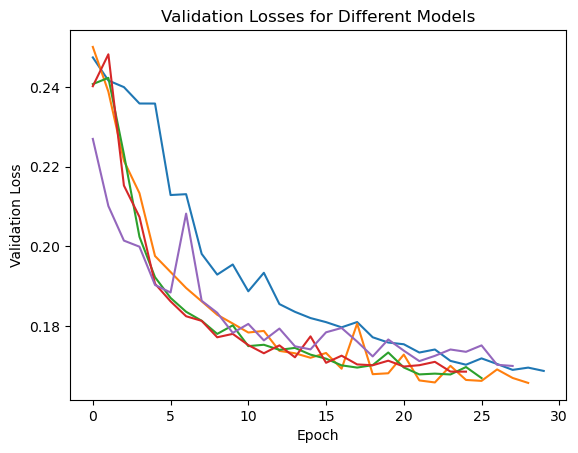

In [ ]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


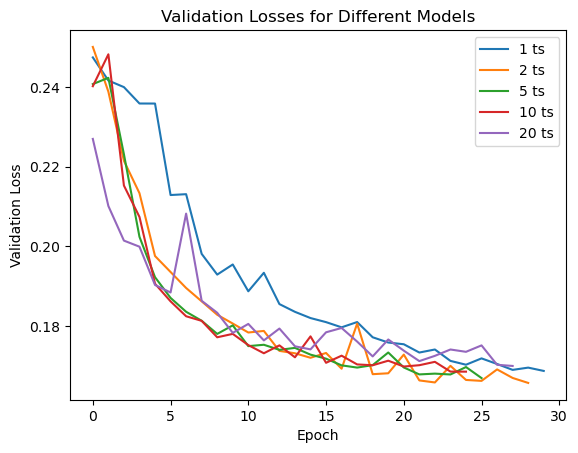

In [8]:

models = [
    'models/VideoClassification_q8_1ts_30e.pt',
    'models/VideoClassification_q8_2ts_29e.pt',
    'models/VideoClassification_q8_5ts_26e.pt',
    'models/VideoClassification_q8_10ts_25e.pt',
    'models/VideoClassification_q8_20ts_28e.pt'
]

for model_path in models:
    model = network.load_model(model_path, network.SCNNVideoClassification, trainset_in, device)
    val_losses = model.training_params['validation_losses']
    plt.plot(val_losses, label=str(model.training_params['num_steps']) + ' ts')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Losses for Different Models')
plt.legend()
plt.show()
    

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

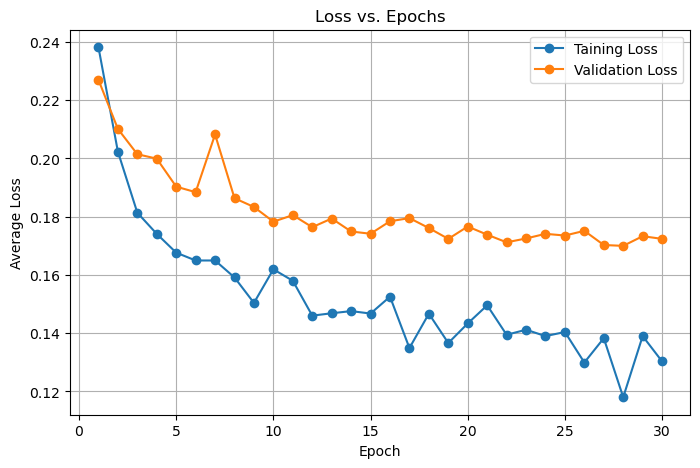

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Error for x_cam: 1.6503 pixels
Average Error for y_cam: 1.2572 pixels
Average Error for R_cam: 0.4407 pixels
Best model error: 2.1209670690434366
Model saved at models/VideoClassification_q8_20ts_28e.pt
Training with num_steps=50
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/30, Training Loss: 0.2162, Validation Loss: 0.2272 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.2089, Validation Loss: 0.2127 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/30, Training Loss: 0.1892, Validation Loss: 0.2042 pixels
Model saved at models/best_model_current_training.pt


KeyboardInterrupt: 

In [3]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [20, 50]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 30

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fiel

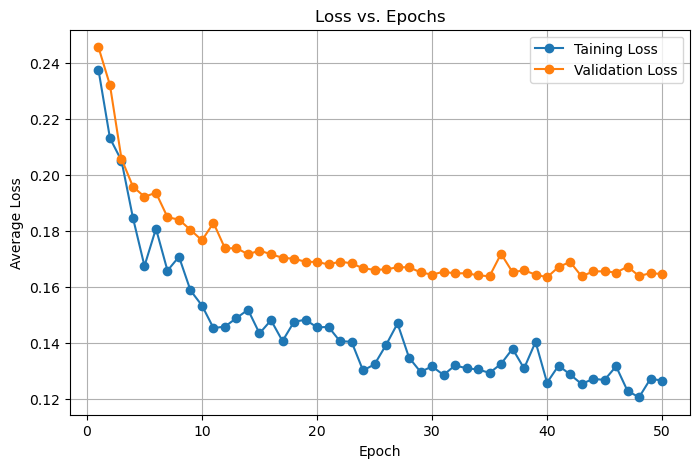

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Average Error for x_cam: 2.0445 pixels
Average Error for y_cam: 0.8083 pixels
Average Error for R_cam: 0.3869 pixels
Best model error: 2.2322429440445375
Model saved at models/VideoClassification_q8_2ts_40e.pt
Training with num_steps=5
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Epoch 1/50, Training Loss: 0.2507, Validation Loss: 0.2944 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/50, Training Loss: 0.2236, Validation Loss: 0.2249 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/50, Training Loss: 0.1877, Validation Loss: 0.2046 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/50, Training Loss: 0.1788, Validation Loss: 0.1938 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/50, Training Loss: 0.1821, Validation Loss: 0.1880 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/50, Training Loss: 0.1729, Validation Loss: 0.2059 pix

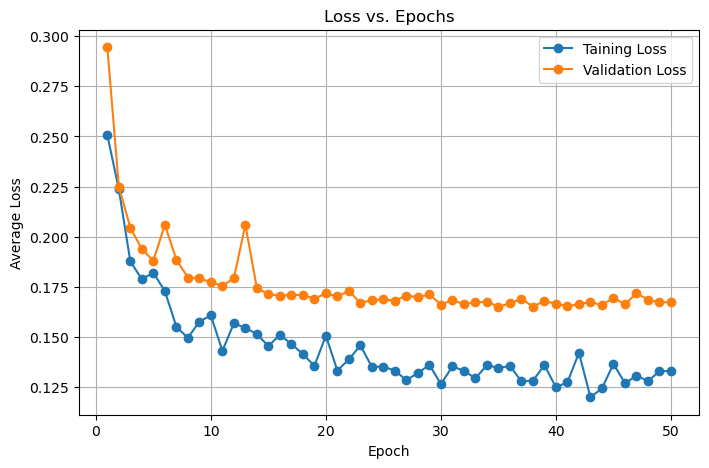

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 1.4983 pixels
Average Error for y_cam: 0.8310 pixels
Average Error for R_cam: 0.4600 pixels
Best model error: 1.7739923535326723
Model saved at models/VideoClassification_q8_5ts_38e.pt


In [2]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [2, 5]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 50

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

In [28]:
dataloader = valid_loader_in

In [29]:
model = network.load_model('models/VideoClassification_q8_5ts_26e.pt', network.SCNNVideoClassification, testset_in, device)
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True)
print(f'Error: {np.linalg.norm(error)}')
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, weighted_avg=True)
print(f'Error: {np.linalg.norm(error)}')

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 1.7514 pixels
Average Error for y_cam: 0.9245 pixels
Average Error for R_cam: 0.4631 pixels
Error: 2.0338295561565225
Evaluating video regression tracker
Average Error for x_cam: 16.2661 pixels
Average Error for y_cam: 7.4748 pixels
Average Error for R_cam: 16.3035 pixels
Error: 24.212933883699534


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Error 0: μ=1.37, σ=5.37, 95% CI=10.204 pixels
Error 1: μ=1.07, σ=3.60, 95% CI=6.997 pixels
Error 2: μ=0.48, σ=1.40, 95% CI=2.785 pixels
Total errors: σ=4.85, 95% CI=11.870 pixels
Evaluating video regression tracker
Error 0: μ=16.25, σ=9.50, 95% CI=31.872 pixels
Error 1: μ=7.17, σ=5.44, 95% CI=16.109 pixels
Error 2: μ=15.58, σ=7.85, 95% CI=28.493 pixels
Total errors: σ=19.23, 95% CI=47.067 pixels


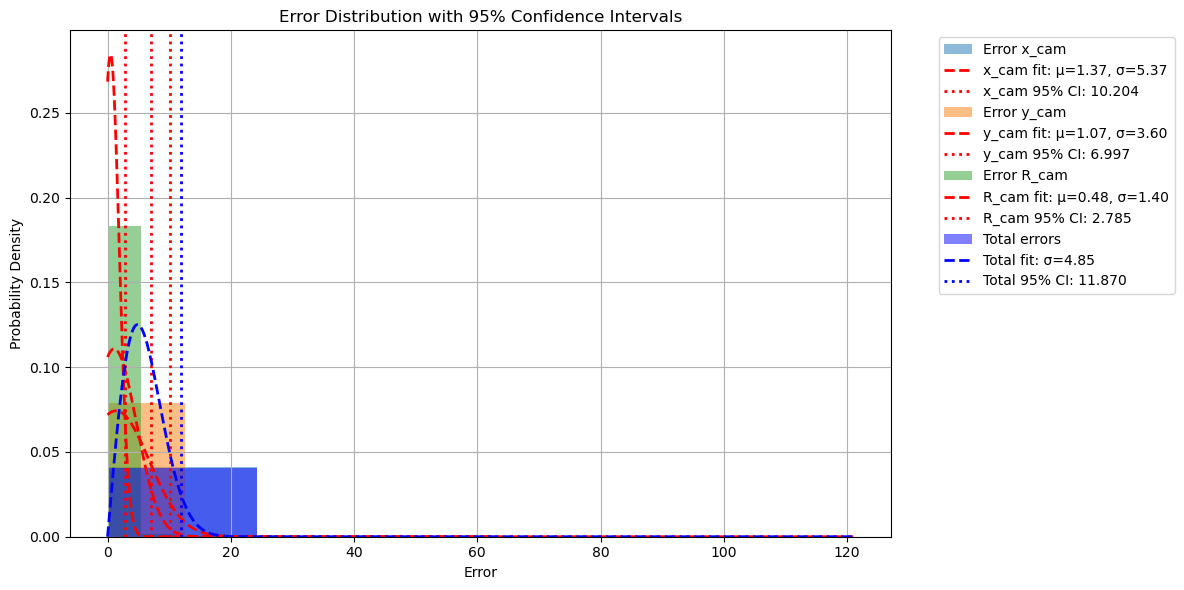

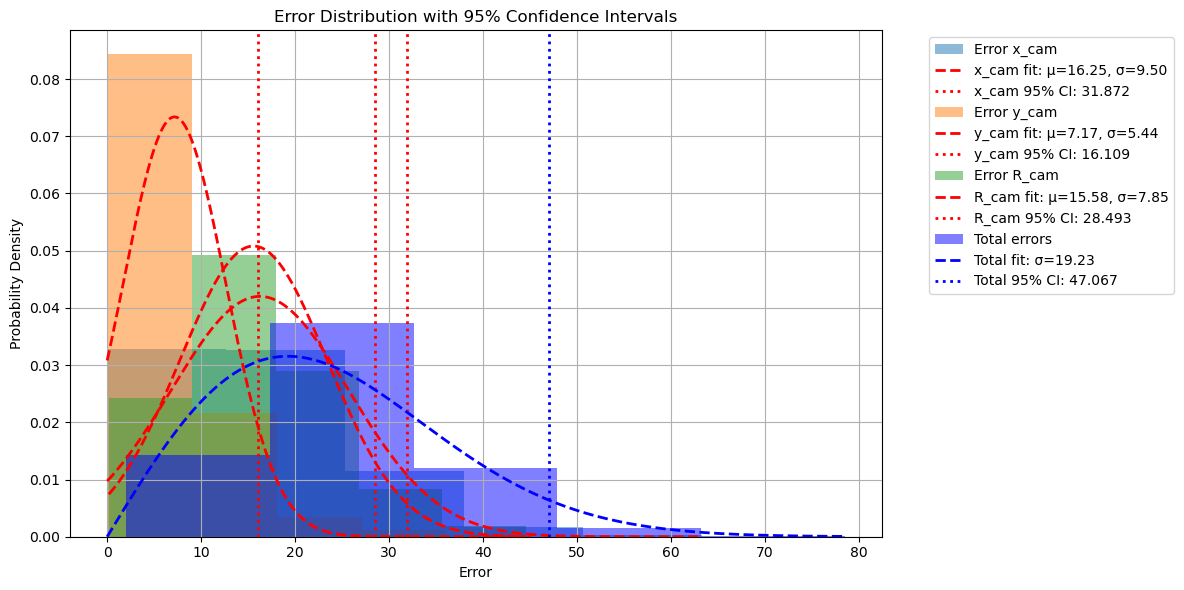

In [34]:
model1 = network.load_model('models/VideoClassification_q8_10ts_25e.pt', network.SCNNVideoClassification, testset_in, device)
error = model1.evaluate(dataloader, device, num_steps=model1.training_params["num_steps"], print_results=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')
error = model1.evaluate(dataloader, device, num_steps=model1.training_params["num_steps"], print_results=True, weighted_avg=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = model_class(trainset, w

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Error 0: μ=1.62, σ=6.74, 95% CI=12.707 pixels
Error 1: μ=0.82, σ=1.53, 95% CI=3.335 pixels
Error 2: μ=0.49, σ=1.31, 95% CI=2.633 pixels
Total errors: σ=5.15, 95% CI=12.601 pixels
Evaluating video regression tracker
Error 0: μ=1.73, σ=4.98, 95% CI=9.912 pixels
Error 1: μ=0.75, σ=1.37, 95% CI=3.015 pixels
Error 2: μ=0.61, σ=1.27, 95% CI=2.700 pixels
Total errors: σ=4.01, 95% CI=9.820 pixels


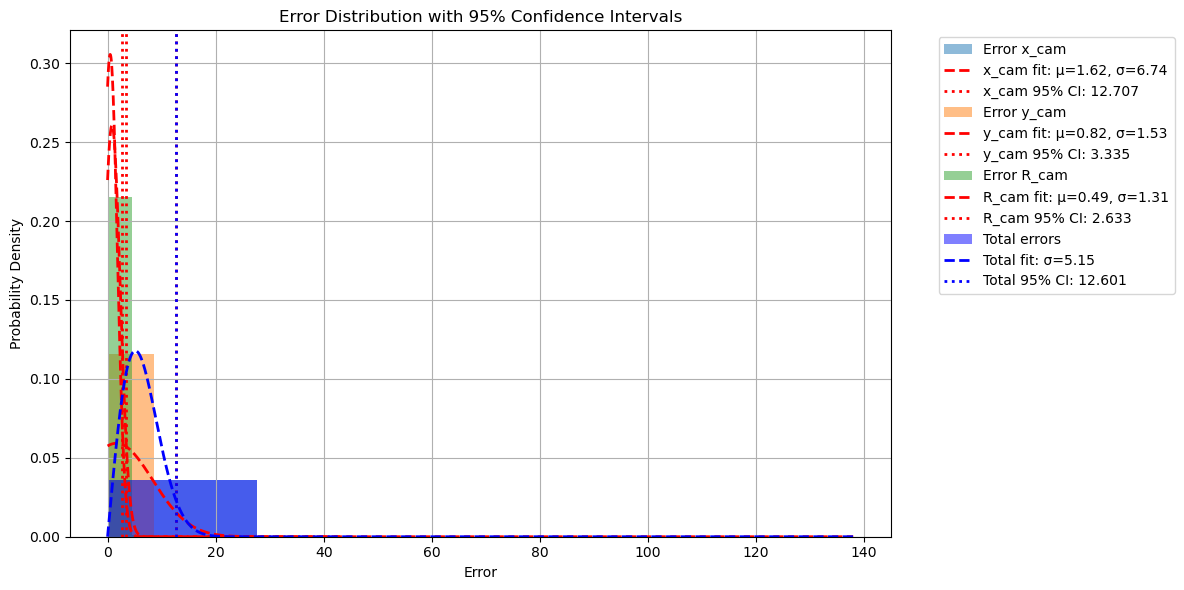

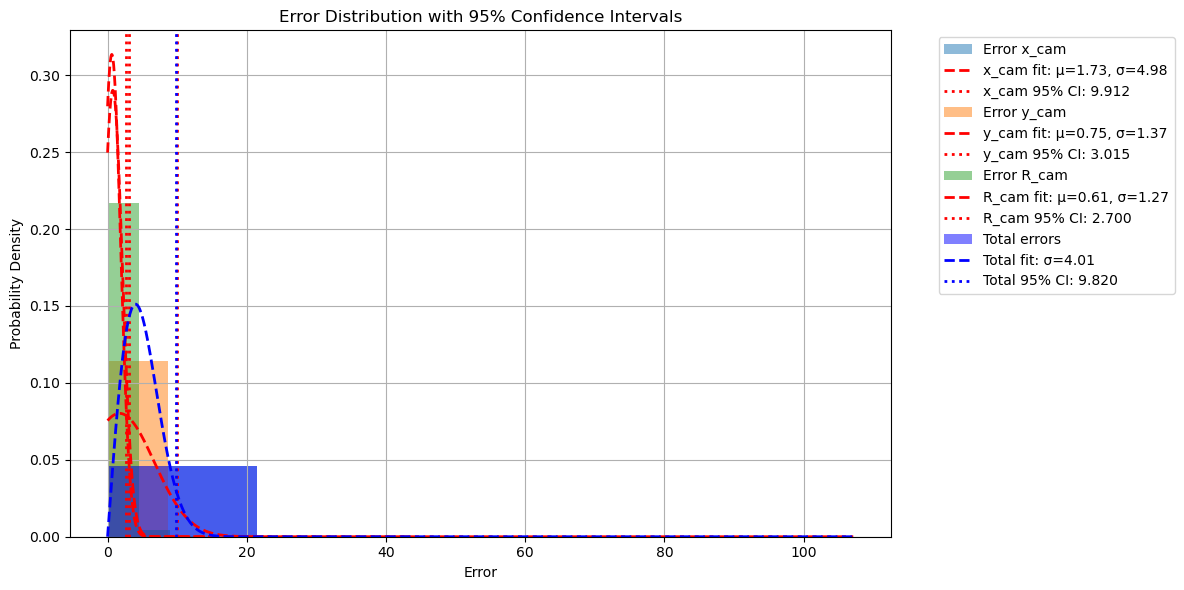

In [37]:
model = network.load_model('models/BEST-VideoClassification-all_lt_aug_q8_10ts_30e.pt', network.SCNNVideoClassification, testset_in, device)
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, weighted_avg=True, operation='distribution')
# print(f'Error: {np.linalg.norm(error)}')

## Kalman Stuff

Results depending on cutoff time

Results depending on distance to the goal

# Exploring Q4

In [3]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 4
batch_size = 4
dataset_type = 'all'
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


timesteps = [5]
for num_steps in timesteps:
    print(f"Training with num_steps={num_steps}")
    model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
    model.ordinal = False
    model.name += f'-{dataset_type}_aug_lt'
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    num_epochs = 50

    # def lr_lambda(step):
    #     warmup_steps = 2 * length_train          # 1 epoch
    #     return min(1.0, step / warmup_steps)

    # warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #                 optimizer,
    #                 T_max = num_epochs*len(trainloader_in),  # full schedule
    #                 eta_min = 1e-5)
    loss_function = network.classification_loss
    model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=10) # I AM TRAINING ON THE TESTLOADER FOR FASTER TRAINING
    network.save_best_model(network.SCNNVideoClassification, valid_loader_in, device, evaluate=True)

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 180, 320])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 180, 320])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 180, 320])
Number of label f

KeyboardInterrupt: 

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequ

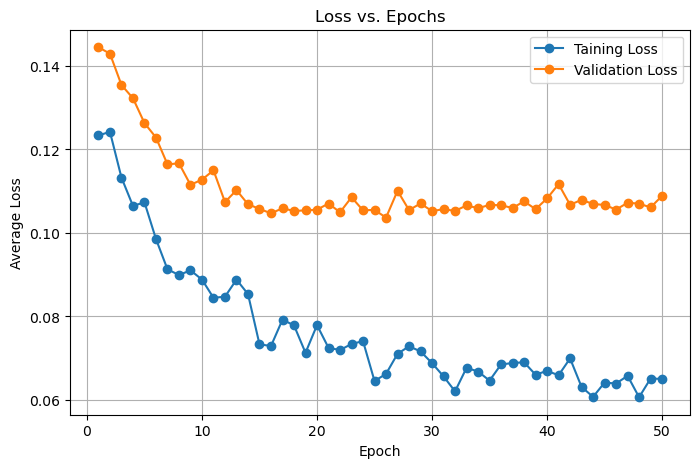

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification_q8_0ts_26e.pt
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2329804800 bytes.

In [2]:
dataset_path = 'data/simulator/dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 10
dataset_type = 'all'
new_positions_csv = f'data/simulator/dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
model.name += f'-{dataset_type}_aug'
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 50

loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequ

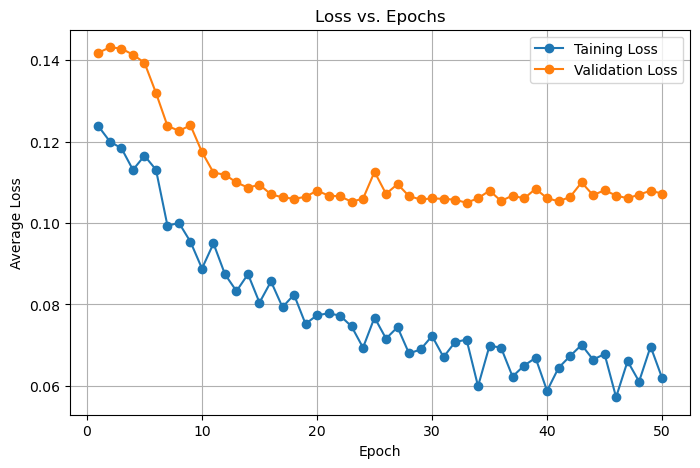

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Number of R_cam bins: 101
Model saved at models/CNNVideoClassification_q8_0ts_33e.pt
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 0.2604 pixels
Average Error for y_cam: -1.5825 pixels
Average Error for R_cam: -0.0178 pixels
Best model error: 1.6038950018223976


In [2]:
dataset_path = 'data/simulator/dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 10
dataset_type = 'all'
new_positions_csv = f'data/simulator/dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
model.name += f'-{dataset_type}_aug_wd1e-4'
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
num_epochs = 50

loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

In [4]:
error = model.evaluate(testloader_in, device, num_steps=0, print_results=True)
print(np.linalg.norm(error))

Evaluating video classification tracker
Average Error for x_cam: 5.4764 pixels
Average Error for y_cam: 3.4119 pixels
Average Error for R_cam: 0.6994 pixels
6.4900612573441725


In [5]:
dataset_path = 'data/simulator/dataset_python_sim2'
accumulation_time = 10 # ms
quantization = 8
batch_size = 10
dataset_type = 'all'
new_positions_csv = f'{dataset_path}/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='all', dataset_type=dataset_type, augment=True)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)

Loading dataset from data/simulator/dataset_python_sim2 with accumulation time 10ms
Loaded 12254 rows from data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Found 87 sequences in data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Final dataset split='all' size: 87



In [7]:
model = network.load_model('models/CNNVideoClassification_q8_0ts_29e_wd1e-2.pt', network.CNNVideoClassification, trainset_in, device)
error = model.evaluate(trainloader_in, device, num_steps=0, print_results=True)
print(np.linalg.norm(error))

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 7.7431 pixels
Average Error for y_cam: 3.0213 pixels
Average Error for R_cam: 0.6379 pixels
8.336098208401031


In [8]:
model = network.load_model('models/CNNVideoClassification_q8_0ts_26e_wd1e-3.pt', network.CNNVideoClassification, trainset_in, device)
error = model.evaluate(trainloader_in, device, num_steps=0, print_results=True)
print(np.linalg.norm(error))

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 3.3113 pixels
Average Error for y_cam: 1.9967 pixels
Average Error for R_cam: 0.4371 pixels
3.8913858883632897


In [9]:
model = network.load_model('models/CNNVideoClassification_q8_0ts_33e_wd1e-4.pt', network.CNNVideoClassification, trainset_in, device)
error = model.evaluate(trainloader_in, device, num_steps=0, print_results=True)
print(np.linalg.norm(error))

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 4.0773 pixels
Average Error for y_cam: 2.1925 pixels
Average Error for R_cam: 0.4503 pixels
4.651214511355008


In [5]:
dataset_path = 'data/simulator/dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 1
dataset_type = 'all'
new_positions_csv = f'data/simulator/dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
model.name += f'-{dataset_type}_aug_wd3e-2'
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=3e-2)
num_epochs = 30

network.measure_inference_time_per_image_for_videos(model, valid_loader_in, device, num_batches=20)

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequ

KeyboardInterrupt: 

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from data/simulator/dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequ

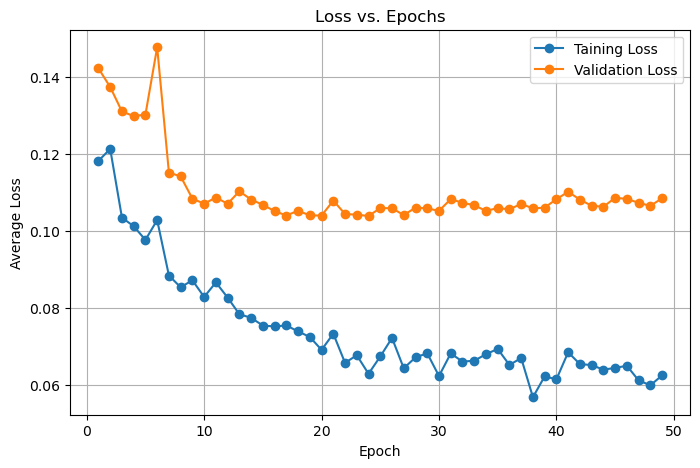

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification_q8_0ts_24e.pt
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Average Error for x_cam: 6.1561 pixels
Average Error for y_cam: 3.0524 pixels
Average Error for R_cam: 0.7045 pixels
Best model error: 6.907346190444612


In [2]:
dataset_path = 'data/simulator/dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 10
dataset_type = 'all'
new_positions_csv = f'data/simulator/dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)


model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
lr = 1e-5
weight_decay = 1e-3
model.name += f'-{dataset_type}_aug_wd{weight_decay}_lr{lr}'
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_epochs = 50

loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
CNNVideoClassification-all_aug_wd0.001_lr1e-05
30
Epoch 1/50, Training Loss: 0.1254, Validation Loss: 0.1527 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/50, Training Loss: 0.1203, Validation Loss: 0.1445 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/50, Training Loss: 0.1158, Validation Loss: 0.1442 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/50, Training Loss: 0.1229, Validation Loss: 0.1433 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/50, Training Loss: 0.1132, Validation Loss: 0.1427 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/50, Training Loss: 0.1209, Validation Loss: 0.1421 pixels
Model saved at models/best_model_current_training.pt
Epoch 7/50, Training Loss: 0.1137, Validation Loss: 0.1419 pixels
Model saved at models/best_model_current_training.pt
Epoch 8/50

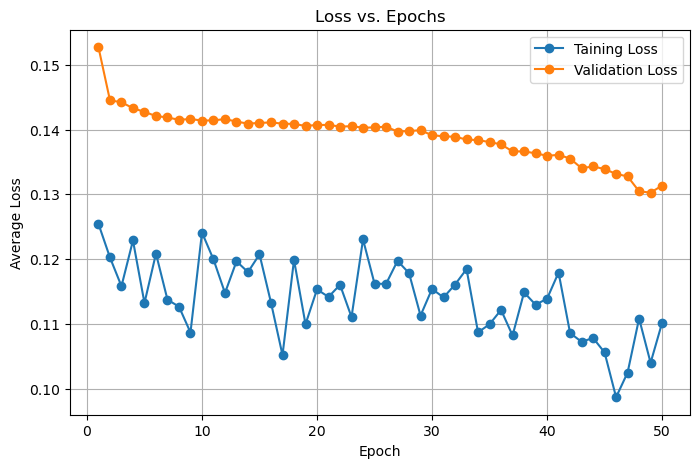

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification_q8_0ts_49e.pt
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Average Error for x_cam: 29.4287 pixels
Average Error for y_cam: 6.5769 pixels
Average Error for R_cam: 1.2338 pixels
Best model error: 30.17990238404678


In [4]:
model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
lr = 1e-5
weight_decay = 1e-3
model.name += f'-{dataset_type}_aug_wd{weight_decay}_lr{lr}'
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
print(model.name)
num_epochs = 50

loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

30
Epoch 1/20, Training Loss: 0.1105, Validation Loss: 0.1303 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/20, Training Loss: 0.1076, Validation Loss: 0.1288 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/20, Training Loss: 0.1071, Validation Loss: 0.1288 pixels
Epoch 4/20, Training Loss: 0.1078, Validation Loss: 0.1303 pixels
Epoch 5/20, Training Loss: 0.1056, Validation Loss: 0.1292 pixels
Epoch 6/20, Training Loss: 0.0979, Validation Loss: 0.1296 pixels
Epoch 7/20, Training Loss: 0.1020, Validation Loss: 0.1289 pixels
Epoch 8/20, Training Loss: 0.1059, Validation Loss: 0.1280 pixels
Model saved at models/best_model_current_training.pt
Epoch 9/20, Training Loss: 0.1064, Validation Loss: 0.1276 pixels
Model saved at models/best_model_current_training.pt
Epoch 10/20, Training Loss: 0.1135, Validation Loss: 0.1289 pixels
Epoch 11/20, Training Loss: 0.1033, Validation Loss: 0.1284 pixels
Epoch 12/20, Training Loss: 0.1056, Validation Loss: 0.12

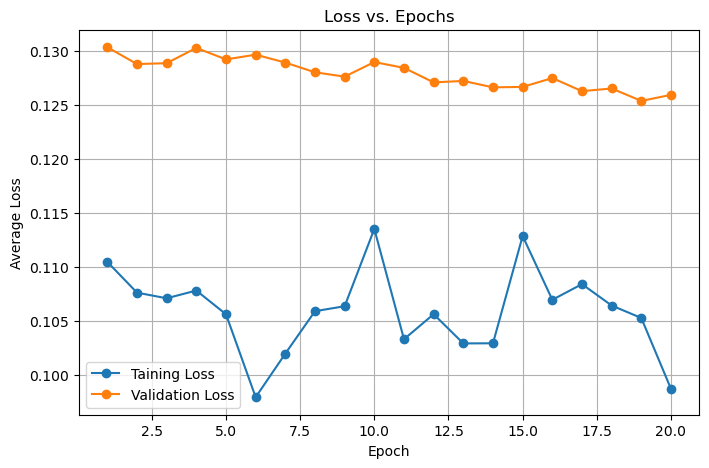

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification-all_aug_wd0.001_lr1e-05_q8_0ts_19e.pt
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Average Error for x_cam: 25.1421 pixels
Average Error for y_cam: 3.7611 pixels
Average Error for R_cam: 1.0636 pixels
Best model error: 25.44412360684222


In [5]:
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=20, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

I try training the model lr 1e-4 wd 1e-3 a little bit with lr 1e-5

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
30
Epoch 1/20, Training Loss: 0.0694, Validation Loss: 0.1039 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/20, Training Loss: 0.0701, Validation Loss: 0.1042 pixels
Epoch 3/20, Training Loss: 0.0686, Validation Loss: 0.1043 pixels
Epoch 4/20, Training Loss: 0.0685, Validation Loss: 0.1043 pixels
Epoch 5/20, Training Loss: 0.0645, Validation Loss: 0.1042 pixels
Epoch 6/20, Training Loss: 0.0659, Validation Loss: 0.1041 pixels
Epoch 7/20, Training Loss: 0.0670, Validation Loss: 0.1045 pixels
Epoch 8/20, Training Loss: 0.0668, Validation Loss: 0.1044 pixels
Epoch 9/20, Training Loss: 0.0684, Validation Loss: 0.1042 pixels
Epoch 10/20, Training Loss: 0.0655, Validation Loss: 0.1044 pixels
Epoch 11/20, Training Loss: 0.0697, Validation Loss: 0.1043 pixels
Epoch 12/20, Training Loss: 0.0659, Validation Loss: 0.1045 pixels

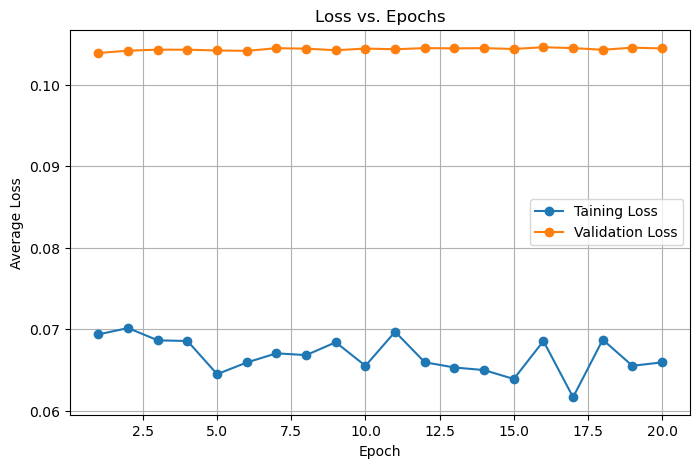

In [6]:
model = network.load_model('models/CNNVideoClassification_q8_0ts_26e_wd1e-3.pt', network.CNNVideoClassification, trainset_in, device)
lr = 1e-5
weight_decay = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=20, chunk_size=30)

Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
CNNVideoClassification-all_aug_wd0.001_lr0.0005
30
Epoch 1/30, Training Loss: 0.1162, Validation Loss: 0.1434 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.1143, Validation Loss: 0.1426 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/30, Training Loss: 0.1225, Validation Loss: 0.1343 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/30, Training Loss: 0.1097, Validation Loss: 0.1284 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/30, Training Loss: 0.0935, Validation Loss: 0.1250 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/30, Training Loss: 0.1052, Validation Loss: 0.1235 pixels
Model saved at models/best_model_current_training.pt
Epoch 7/30, Training Loss: 0.0977, Validation Loss: 0.1188 pixels
Model saved at models/best_model_current_training.pt
Epoch 8/3

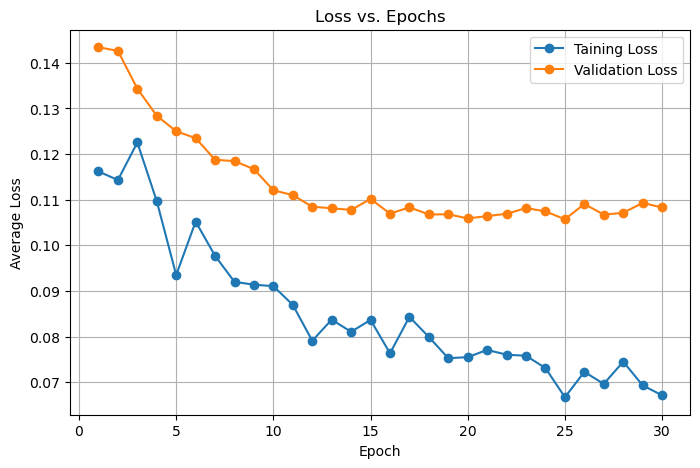

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification-all_aug_wd0.001_lr0.0005_q8_0ts_25e.pt
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Average Error for x_cam: 9.0491 pixels
Average Error for y_cam: 3.4722 pixels
Average Error for R_cam: 0.7326 pixels
Best model error: 9.7200173865358
30
Epoch 1/30, Training Loss: 0.0674, Validation Loss: 0.1068 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/30, Training Loss: 0.0654, Validation Loss: 0.1067 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/30, Training Loss: 0.0673, Validation Loss: 0.1069 pixels
Epoch 4/30, Training Loss: 0.0690, Validation Loss: 0.1073 pixels
Epoch 5/30, Training Loss: 0.0663, Validation Loss: 0.1071 pixels
Epoch 6/30, Training Loss: 0.0638, Validation Loss: 0.1075 pixels
Epoch 7/30, Training Loss: 0.0658, Validation Loss: 0.1071 pixels
Epoch 8/30, Training Loss: 0.0664, Validation Loss: 0.1079 pixels
Epoch 9/30, Training Loss: 0.0683, Validation Loss: 0.1070 pixels
Epoch 10/30, Training Loss: 0.0652, Validation Loss: 0.1072 pixels
Epoch 11/30, Training Loss: 0.0682, Validation Loss: 0.1081 pixels
Epoch 12/30,

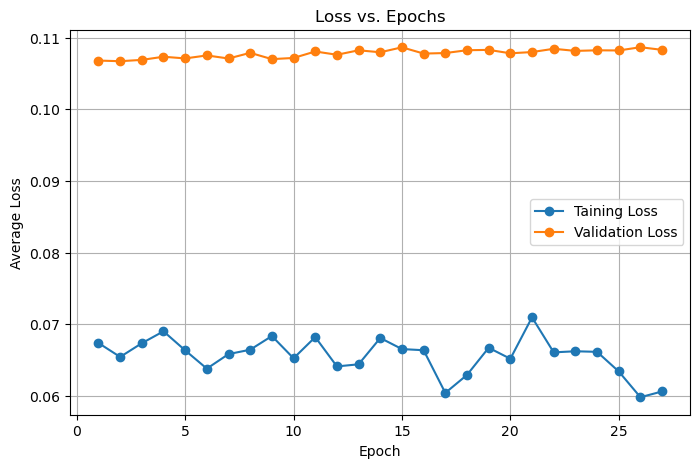

Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification-all_aug_wd0.001_lr0.0005_q8_0ts_2e.pt
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 5.9042 pixels
Average Error for y_cam: 3.2291 pixels
Average Error for R_cam: 0.6709 pixels
Best model error: 6.762849881045714


In [14]:
model = network.CNNVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
lr = 5e-4
weight_decay = 1e-3
model.name += f'-{dataset_type}_aug_wd{weight_decay}_lr{lr}'
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
print(model.name)
num_epochs = 30

loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

new_lr = 1e-4
for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=30, chunk_size=30)
network.save_best_model(network.CNNVideoClassification, testloader_in, device, evaluate=True)

Flattened feature size: 6400
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
CNNVideoClassification-all_aug_wd0.001_lr0.0005
30
Epoch 1/50, Training Loss: 0.1289, Validation Loss: 0.1450 pixels
Model saved at models/best_model_current_training.pt
Epoch 2/50, Training Loss: 0.1156, Validation Loss: 0.1410 pixels
Model saved at models/best_model_current_training.pt
Epoch 3/50, Training Loss: 0.1085, Validation Loss: 0.1328 pixels
Model saved at models/best_model_current_training.pt
Epoch 4/50, Training Loss: 0.1037, Validation Loss: 0.1272 pixels
Model saved at models/best_model_current_training.pt
Epoch 5/50, Training Loss: 0.1004, Validation Loss: 0.1215 pixels
Model saved at models/best_model_current_training.pt
Epoch 6/50, Training Loss: 0.0957, Validation Loss: 0.1172 pixels
Model saved at models/best_model_current_training.pt
Epoch 7/50, Training Loss: 0.0929, Validation Loss: 0.1130 pixels
Model saved at models/best_model_current_training.pt
Epoch 8/50

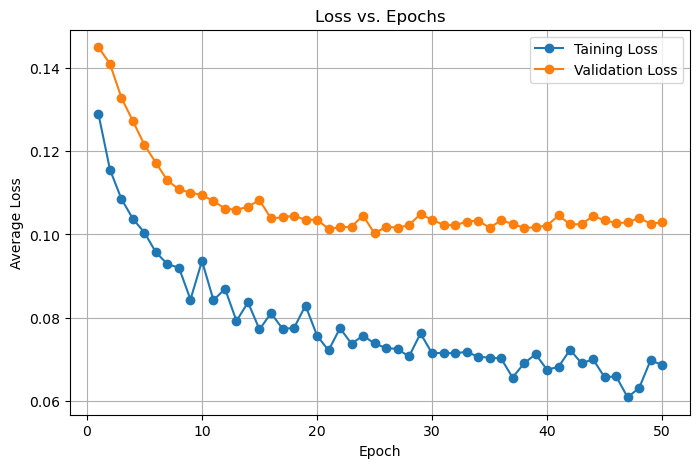

Loading best model...
Loading model with weighted average: False
Flattened feature size: 6400
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Model saved at models/CNNVideoClassification-all_aug_wd0.001_lr0.0005_q8_0ts_25e.pt
Best model evaluation...
Evaluating video classification tracker
Average Error for x_cam: 2.9738 pixels
Average Error for y_cam: 2.1861 pixels
Average Error for R_cam: 0.6162 pixels
Best model error: 3.7419473117391724


In [15]:
model = network.CNN4LVideoClassification(trainset_in, weighted_avg=False).to(device)
model.ordinal = False
lr = 5e-4
weight_decay = 1e-3
model.name += f'-{dataset_type}_aug_wd{weight_decay}_lr{lr}'
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
print(model.name)
num_epochs = 50

loss_function = network.classification_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.CNN4LVideoClassification, testloader_in, device, evaluate=True)


In [2]:
dataset_path = 'data/simulator/dataset_python_sim2'
accumulation_time = 10 # ms
quantization = 8
batch_size = 1
dataset_type = 'all'
new_positions_csv = f'{dataset_path}/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='all', dataset_type=dataset_type, augment=True)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)


Loading dataset from data/simulator/dataset_python_sim2 with accumulation time 10ms
Loaded 12254 rows from data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Found 87 sequences in data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Final dataset split='all' size: 87



In [5]:

model = network.load_model('models/CNNVideoClassification-all_aug_wd0.001_lr0.0005_q8_0ts_25e.pt', network.CNN4LVideoClassification, trainset_in, device)
error = model.evaluate(trainloader_in, device, num_steps=0, print_results=True)
print(np.linalg.norm(error))

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

Loading model with weighted average: False
Flattened feature size: 6400
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Evaluating video classification tracker
Average Error for x_cam: 2.4557 pixels
Average Error for y_cam: 1.4204 pixels
Average Error for R_cam: 0.4127 pixels
2.866788139068297


In [8]:
network.measure_inference_time_per_image_for_videos(model, trainloader_in, device, num_batches=100)

Average inference time per image over 87 batches: 0.002341 s


0.00234139333891096

# Plotting weights

In [3]:
import os
import math
import torch
import matplotlib.pyplot as plt

def _safe_title(name):
    return name.replace(".", "_").replace("/", "_")

def _normalize(x):
    x = x.clone().float()
    x -= x.min()
    denom = (x.max() - x.min()).clamp(min=1e-8)
    return x / denom

def plot_conv_filters(w, title, max_kernels=64, avg_across_in_channels=True, save_path=None):
    # w: (out_c, in_c, kH, kW)
    w = w.detach().cpu()
    out_c, in_c, kH, kW = w.shape

    # Collapse input channels for visualization (else show first channel)
    if avg_across_in_channels:
        vis = w.mean(dim=1)  # (out_c, kH, kW)
    else:
        vis = w[:,0,:,:]     # first input channel

    vis = _normalize(vis)

    n_k = min(out_c, max_kernels)
    n_cols = min(8, n_k)
    n_rows = math.ceil(n_k / n_cols)

    plt.figure(figsize=(1.7*n_cols, 1.7*n_rows))
    for i in range(n_k):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(vis[i].numpy(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

def plot_linear_heatmap(w, title, save_path=None):
    # w: (out_features, in_features)
    w = w.detach().cpu()
    plt.figure(figsize=(8, 4))
    plt.imshow(w.numpy(), aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

def plot_histogram(tensor, title, bins=60, save_path=None):
    x = tensor.detach().cpu().flatten().numpy()
    plt.figure(figsize=(5,3))
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

def visualize_model_weights(model, save_dir=None, max_kernels=64, avg_across_in_channels=True):
    """
    Visualize conv filters, dense heatmaps, and histograms for weights/biases.
    Attempts to plot common spiking parameters if present (e.g., thresholds).
    """
    # 1) Layer-wise visuals
    for name, module in model.named_modules():
        # Convolutional layers
        if hasattr(module, "weight") and module.__class__.__name__.lower().startswith("conv"):
            w = module.weight
            title = f"{name}: {module.__class__.__name__} filters"
            save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_conv_filters.png")
            try:
                plot_conv_filters(w, title, max_kernels=max_kernels, avg_across_in_channels=avg_across_in_channels, save_path=save_path)
            except Exception as e:
                print(f"[WARN] Could not plot filters for {name}: {e}")

            # weight histogram
            save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_conv_w_hist.png")
            plot_histogram(w, f"{name}: conv weight histogram", save_path=save_path)

            # bias histogram
            if getattr(module, "bias", None) is not None:
                save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_conv_b_hist.png")
                plot_histogram(module.bias, f"{name}: conv bias histogram", save_path=save_path)

        # Linear layers
        elif hasattr(module, "weight") and module.__class__.__name__.lower().startswith("linear"):
            w = module.weight
            title = f"{name}: {module.__class__.__name__} weights (heatmap)"
            save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_linear_heatmap.png")
            plot_linear_heatmap(w, title, save_path=save_path)

            save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_linear_w_hist.png")
            plot_histogram(w, f"{name}: linear weight histogram", save_path=save_path)

            if getattr(module, "bias", None) is not None:
                save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_linear_b_hist.png")
                plot_histogram(module.bias, f"{name}: linear bias histogram", save_path=save_path)

        # BatchNorm (if present) — useful to inspect gamma/beta
        elif module.__class__.__name__.lower().startswith("batchnorm"):
            if getattr(module, "weight", None) is not None:
                save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_bn_gamma_hist.png")
                plot_histogram(module.weight, f"{name}: BatchNorm gamma histogram", save_path=save_path)
            if getattr(module, "bias", None) is not None:
                save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_bn_beta_hist.png")
                plot_histogram(module.bias, f"{name}: BatchNorm beta histogram", save_path=save_path)

        # Try common spiking parameters (thresholds, time constants, etc.)
        # Adjust/extend these attribute names to match your SCNN implementation.
        for attr in ["threshold", "v_th", "thresh", "vth", "tau_m", "tau_syn", "beta"]:
            if hasattr(module, attr):
                param = getattr(module, attr)
                if torch.is_tensor(param):
                    save_path = None if save_dir is None else os.path.join(save_dir, f"{_safe_title(name)}_{attr}_hist.png")
                    plot_histogram(param, f"{name}: {attr} histogram", save_path=save_path)

    # 2) Global histogram across ALL parameters (good quick sanity check)
    all_params = []
    for p in model.parameters():
        if p is not None and p.numel() > 0:
            all_params.append(p.detach().cpu().flatten())
    if all_params:
        all_params = torch.cat(all_params)
        save_path = None if save_dir is None else os.path.join(save_dir, f"__all_params_hist.png")
        plot_histogram(all_params, "All parameters histogram", save_path=save_path)



In [4]:
# --- Example usage ---
# model = ...  # your trained SCNN (PyTorch nn.Module)
# visualize_model_weights(model, save_dir="scnn_plots", max_kernels=64, avg_across_in_channels=True)
# If you prefer just showing on screen, pass save_dir=None.

In [6]:
# model = network.load_model('models/BEST-VideoClassification_q8_5ts_38e.pt', network.SCNNVideoClassification, trainset_in, device)
visualize_model_weights(model, save_dir="scnn_plots", max_kernels=64, avg_across_in_channels=True)

In [7]:
import math
import torch
import matplotlib.pyplot as plt

def _normalize_img(x, eps=1e-8):
    x = x - x.min()
    denom = (x.max() - x.min()).clamp(min=eps)
    return x / denom

def visualize_conv2d_kernels(conv, title=None, max_out=16, max_in=8, per_kernel_norm=True):
    """
    Visualize Conv2d kernels as a 2D grid: rows = out_channels, cols = in_channels.
    Each cell is a kxk image of that kernel (optionally normalized per-kernel).
    """
    assert hasattr(conv, "weight"), "Pass a nn.Conv2d module"
    w = conv.weight.detach().cpu()  # (out_c, in_c, kH, kW)
    out_c, in_c, kH, kW = w.shape

    # limit grid size
    o = min(out_c, max_out)
    c = min(in_c, max_in)

    # compute figure size
    fig_w = c * 2.0
    fig_h = o * 2.0
    plt.figure(figsize=(fig_w, fig_h))
    plt.suptitle(title or f"{type(conv).__name__} kernels ({kH}×{kW})", y=0.99)

    for i in range(o):
        for j in range(c):
            kernel = w[i, j, :, :].clone()
            if per_kernel_norm:
                vis = _normalize_img(kernel)
            else:
                vis = kernel  # global normalization via color scale is messy; per-kernel is clearer
            ax = plt.subplot(o, c, i * c + j + 1)
            ax.imshow(vis.numpy(), cmap="gray", interpolation="nearest")
            ax.set_xticks([]); ax.set_yticks([])
            if i == 0:
                ax.set_title(f"in {j}", fontsize=8)
            if j == 0:
                ax.set_ylabel(f"out {i}", fontsize=8)
    plt.tight_layout()
    plt.show()

def visualize_linear_as_spatial(linear, prev_shape, out_indices=None, reduce="l2", title=None):
    """
    Visualize a Linear layer's weights as 2D spatial maps, assuming the linear
    receives flattened conv features of shape prev_shape=(C,H,W).
    We unflatten each neuron's weight vector to (C,H,W) and reduce across C.

    reduce ∈ {"l2", "absmean", "max"} controls how channels collapse to 2D.
    """
    assert hasattr(linear, "weight"), "Pass a nn.Linear module"
    C, H, W = prev_shape
    Wmat = linear.weight.detach().cpu()  # (out_features, in_features)
    assert Wmat.shape[1] == C * H * W, \
        f"Expected in_features={C*H*W}, got {Wmat.shape[1]} — prev_shape may be wrong."

    out_feats = Wmat.shape[0]
    if out_indices is None:
        # show first few neurons by default (fits nicely in a grid)
        n_show = min(12, out_feats)
        out_indices = list(range(n_show))

    # choose grid layout
    n = len(out_indices)
    n_cols = min(4, n)
    n_rows = math.ceil(n / n_cols)

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    plt.suptitle(title or f"{type(linear).__name__} weights as spatial maps", y=0.98)

    for k, idx in enumerate(out_indices):
        wvec = Wmat[idx]                         # (C*H*W,)
        w3d = wvec.view(C, H, W).clone()        # (C,H,W)

        if reduce == "l2":
            vis = torch.sqrt((w3d ** 2).sum(dim=0))  # (H,W)
        elif reduce == "absmean":
            vis = w3d.abs().mean(dim=0)
        elif reduce == "max":
            vis = w3d.abs().max(dim=0).values
        else:
            raise ValueError("reduce must be one of {'l2','absmean','max'}")

        vis = _normalize_img(vis)

        ax = plt.subplot(n_rows, n_cols, k + 1)
        ax.imshow(vis.numpy(), cmap="gray", interpolation="nearest")
        ax.set_title(f"out #{idx}", fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    plt.show()


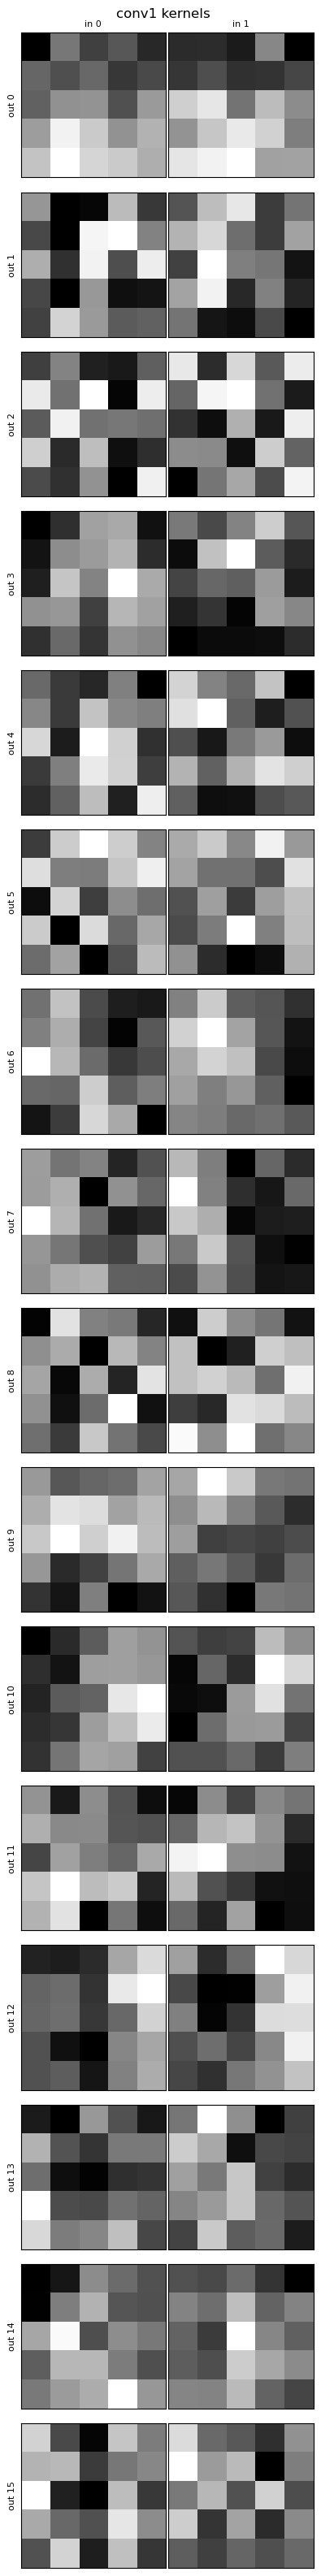

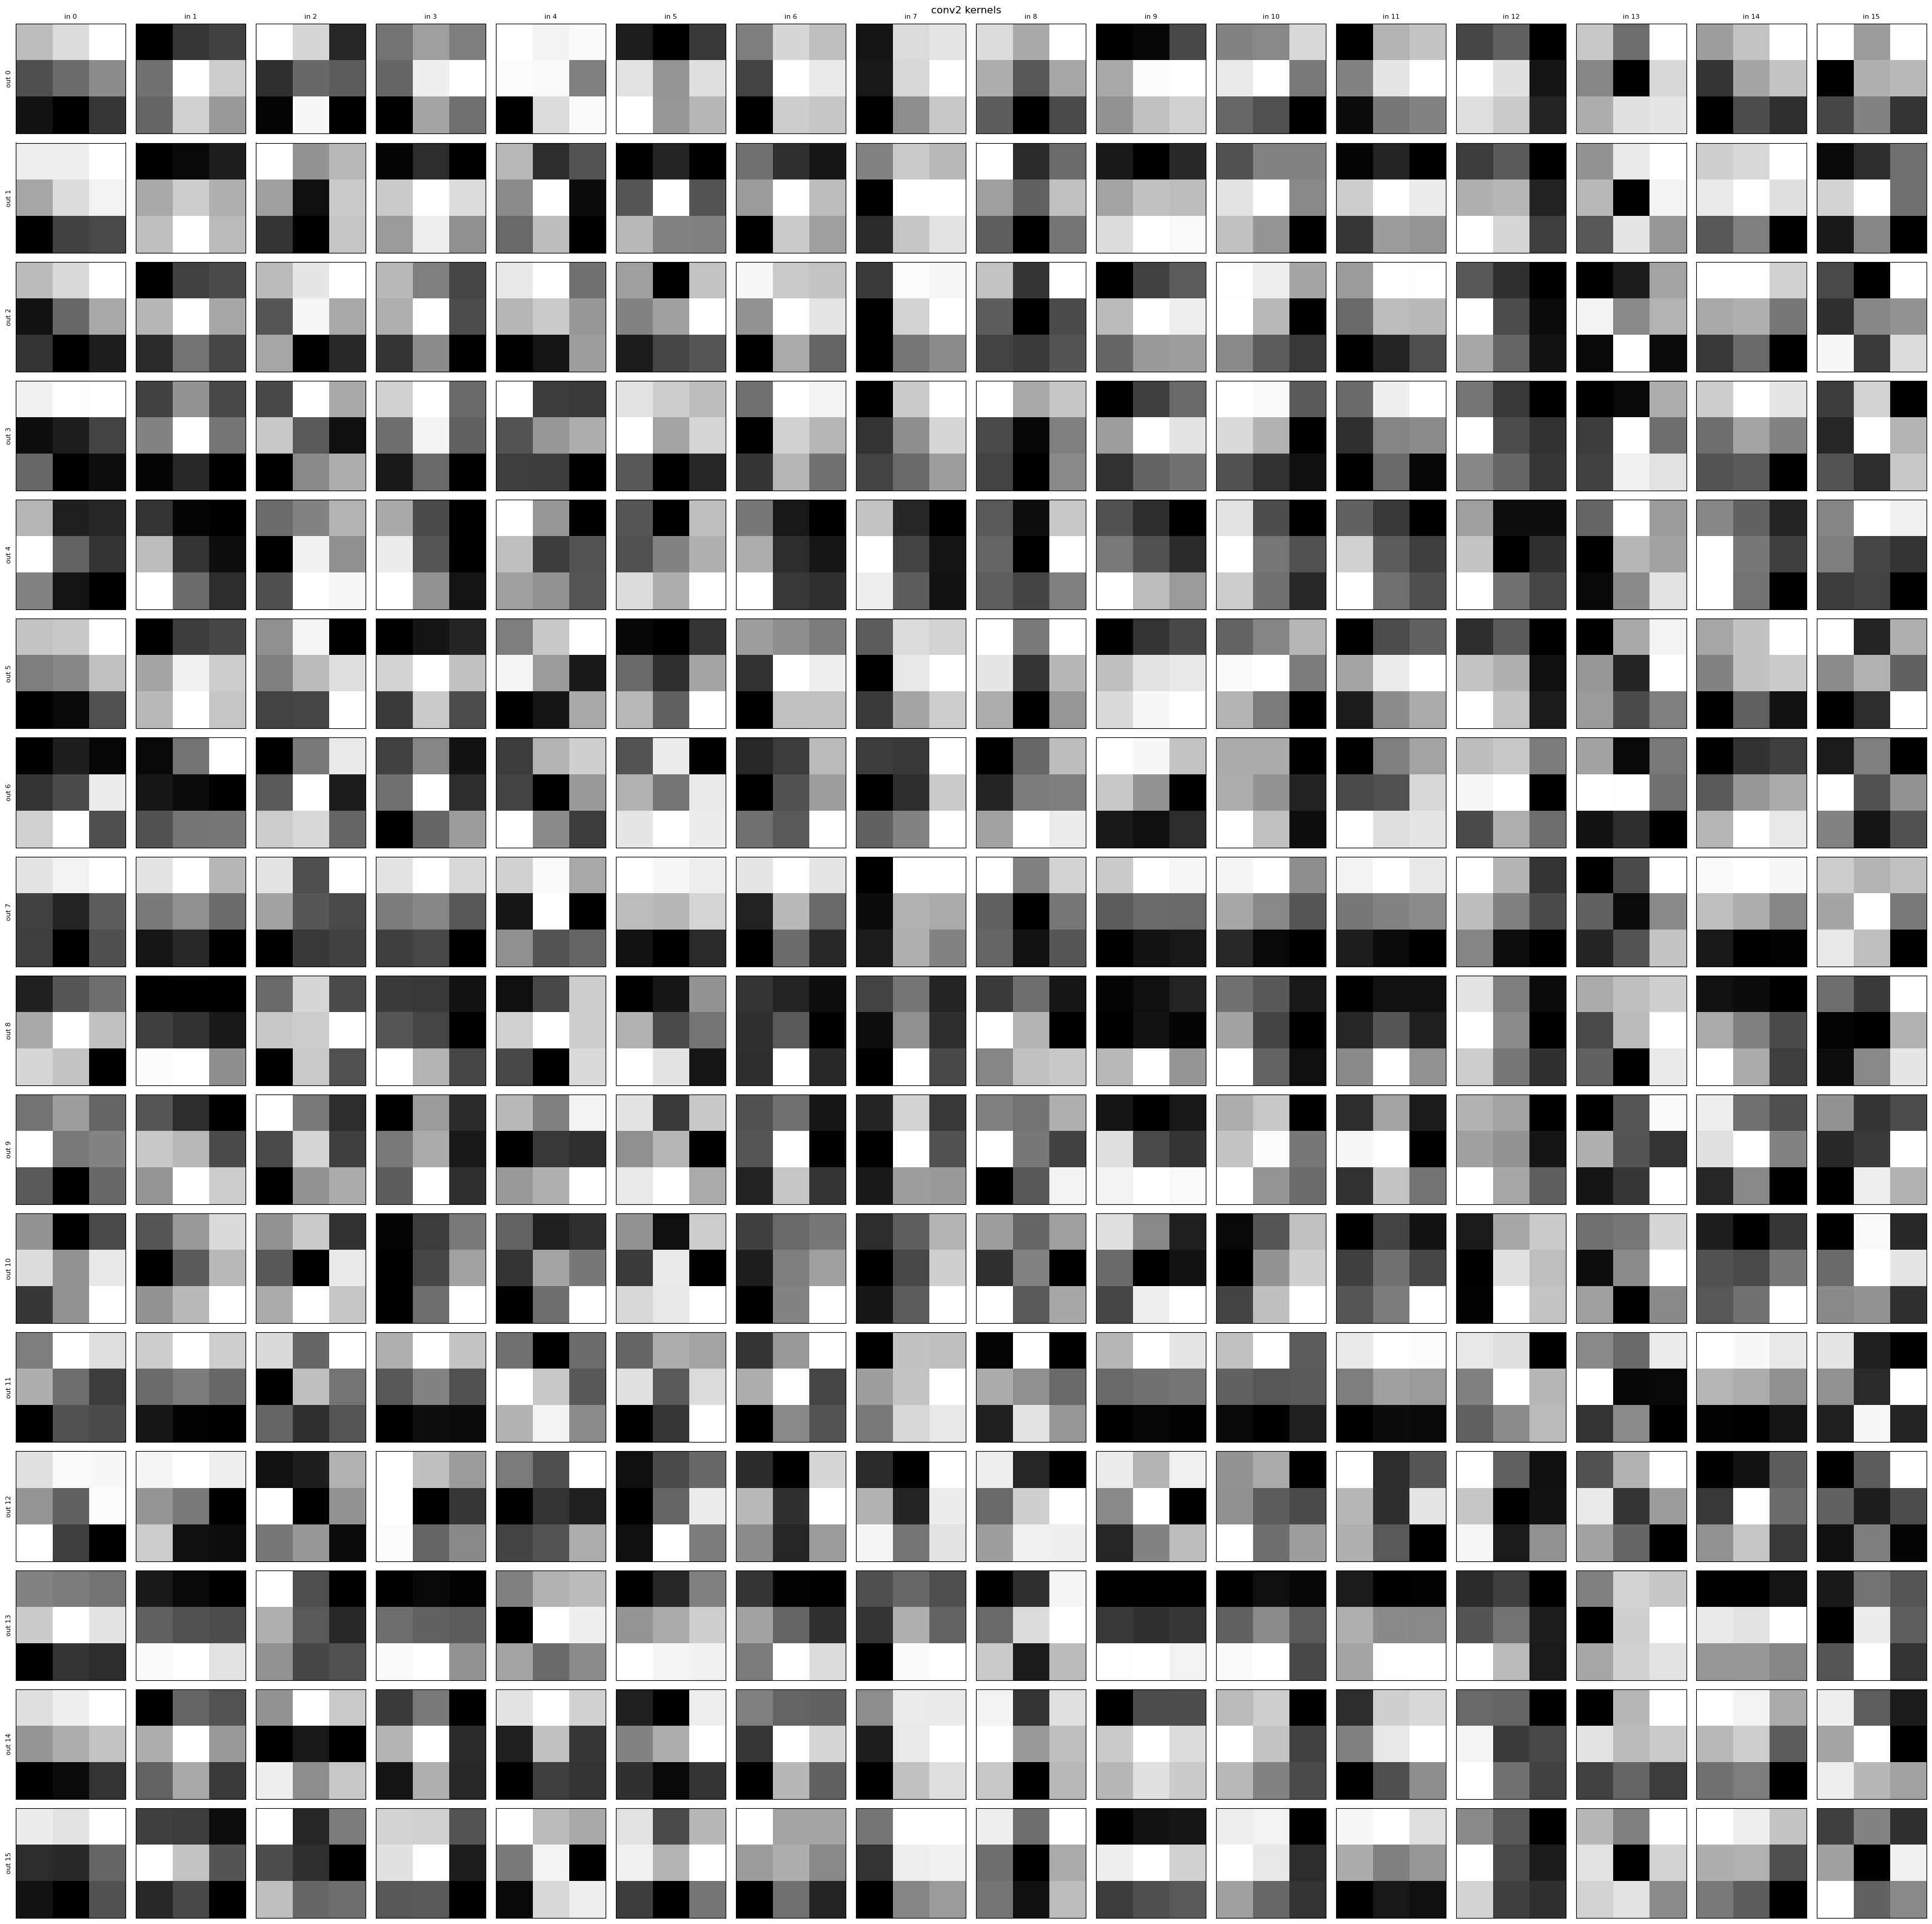

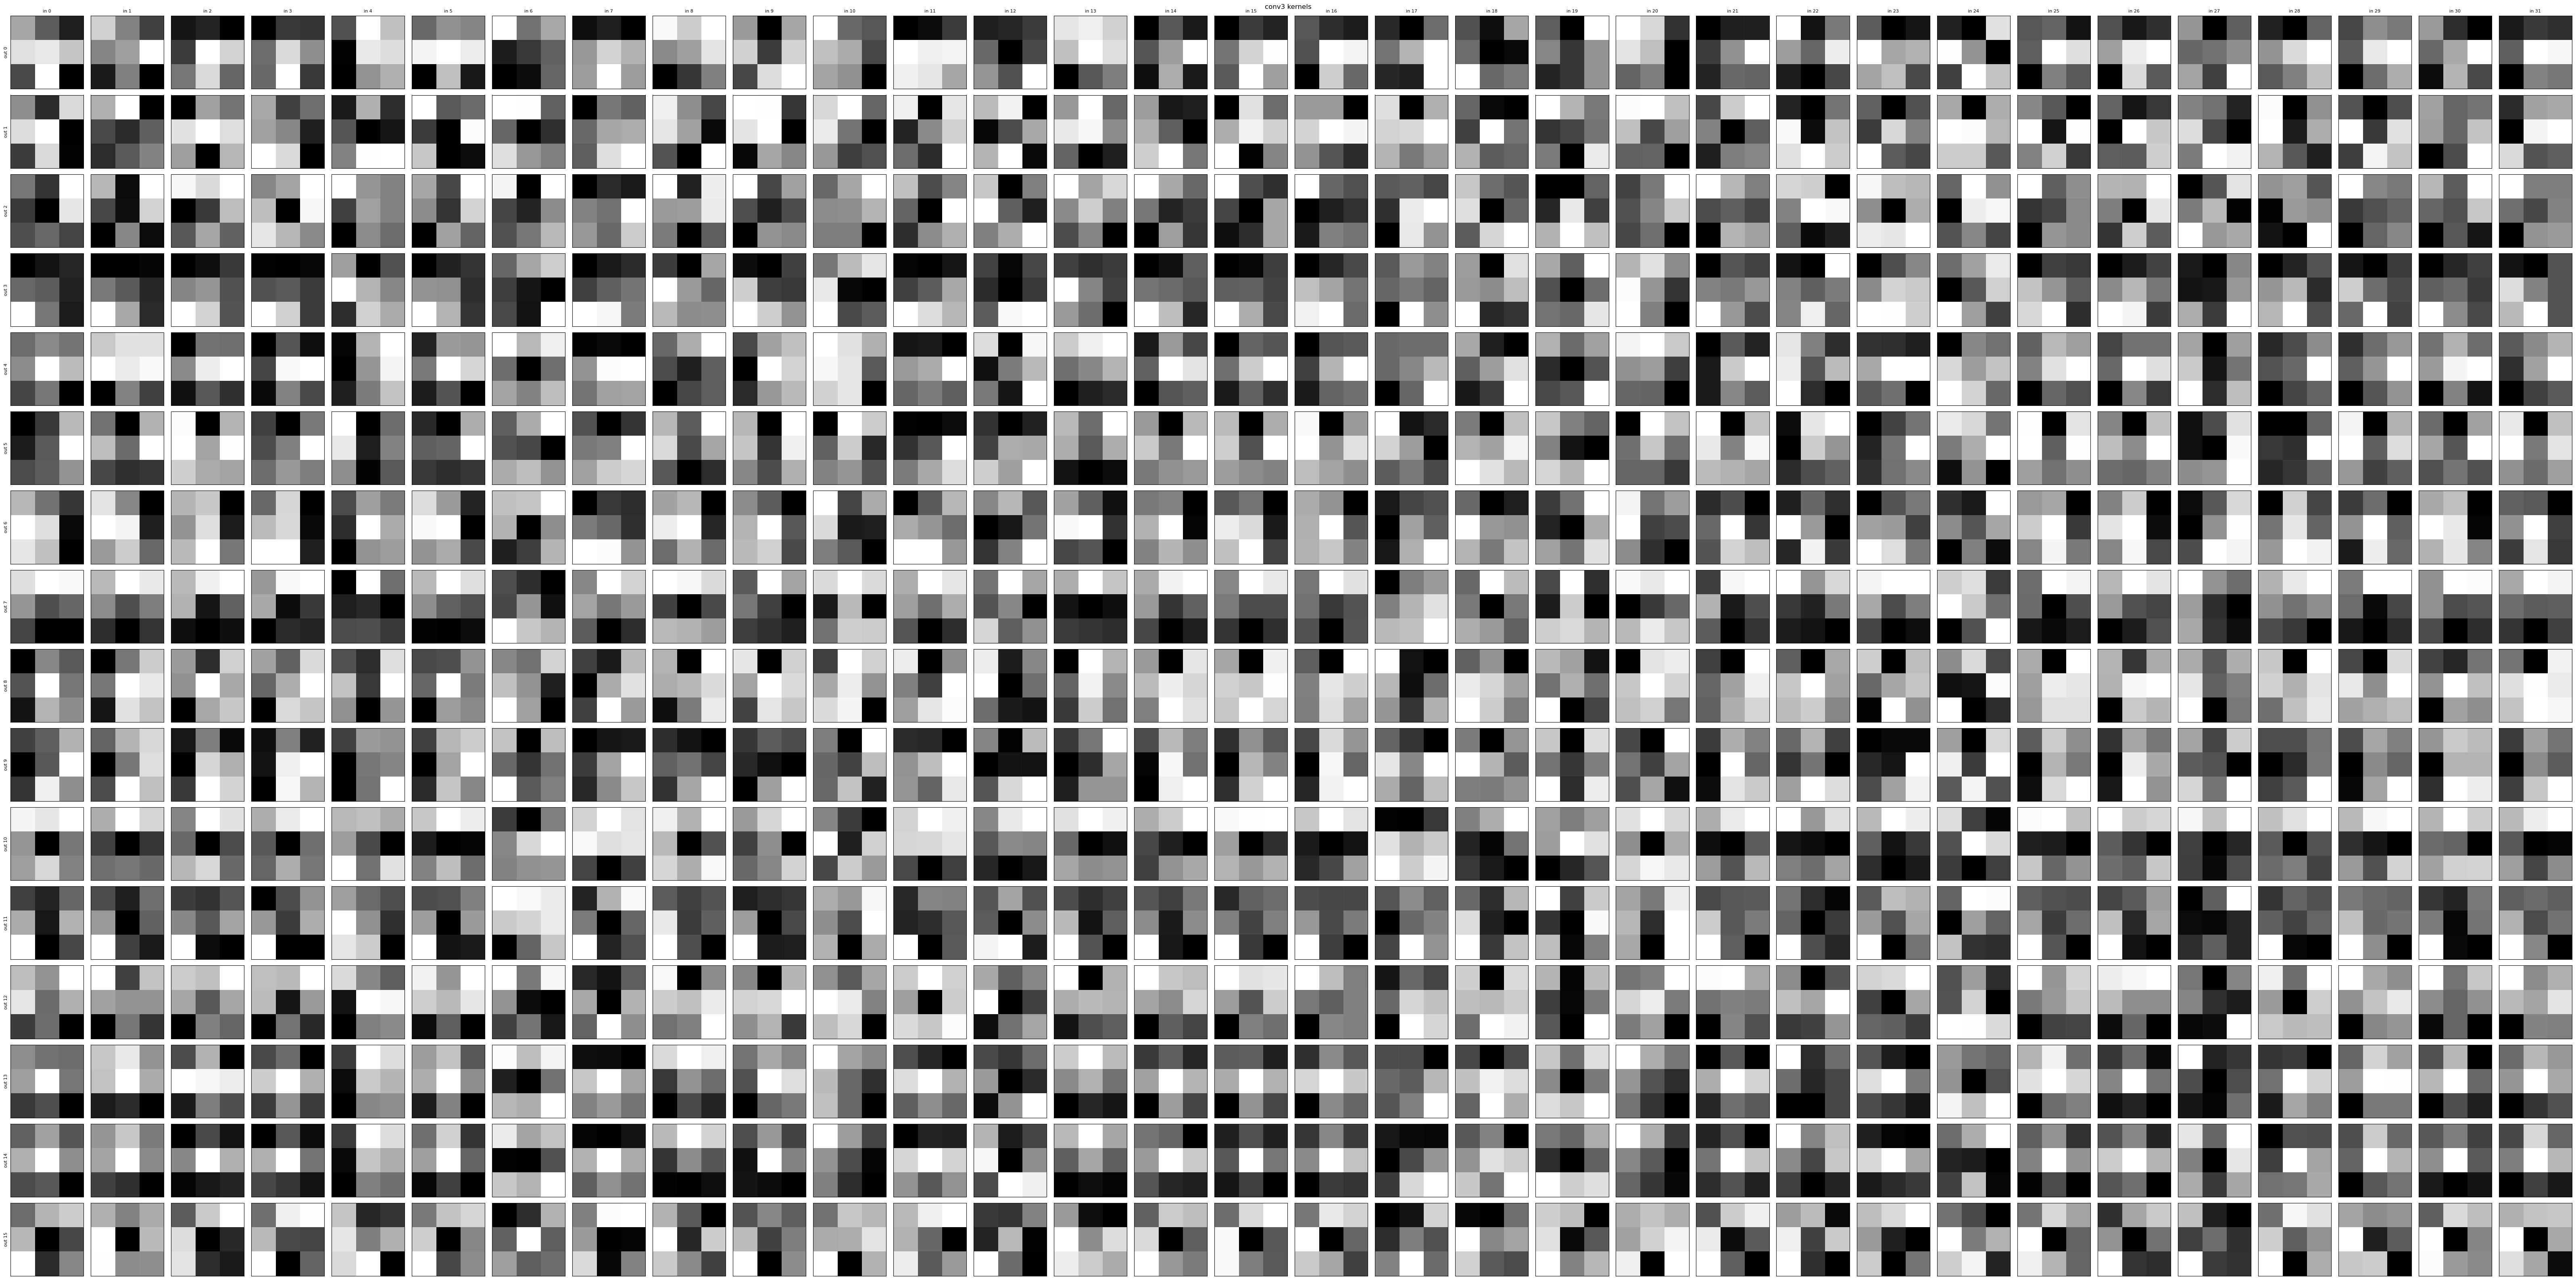

In [13]:
# Example: visualize conv layers
visualize_conv2d_kernels(model.conv1, title="conv1 kernels", max_out=16, max_in=3)
visualize_conv2d_kernels(model.conv2, title="conv2 kernels", max_out=16, max_in=16)
visualize_conv2d_kernels(model.conv3, title="conv3 kernels", max_out=16, max_in=32)

# Example: visualize a linear layer that follows a conv backbone
# You need the feature shape that feeds into the linear (C,H,W) before flattening.
# Suppose your backbone outputs (batch, 32, 10, 18) → flattened to 5760 before linear.
# visualize_linear_as_spatial(model.fc_layers['x_cam'], prev_shape=(32, 10, 18), out_indices=range(8), reduce="l2")
